<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/diciembre_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 23.7824 - mae: 4.3498 - val_loss: 18.5358 - val_mae: 3.7964 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.4144 - mae: 3.2564 - val_loss: 8.7613 - val_mae: 2.5146 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4325 - mae: 2.3345 - val_loss: 4.3366 - val_mae: 1.7294 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3408 - mae: 2.0095 - val_loss: 3.8698 - val_mae: 1.6326 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2213 - mae: 2.0063 - val_loss: 3.8581 - val_mae: 1.6379 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6996 - mae: 1.9354 - val_loss: 3.5349 - val_mae: 1.5699 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1820 - mae: 1.8286 - val_loss: 3.5077 - val_mae: 1.5690 - learning_rate: 0.0010
Epoch 8/

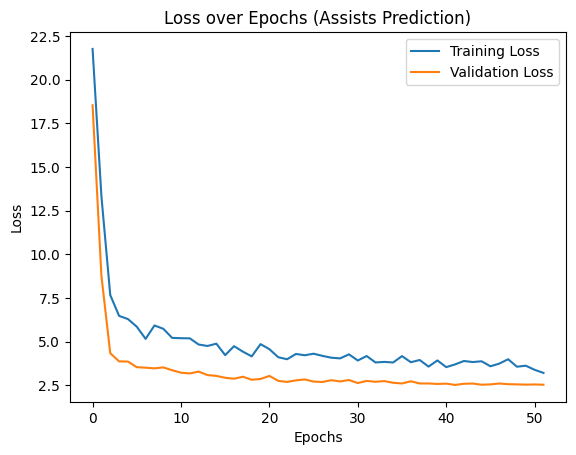

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted total assists for the player's next game: 5.76


5.757731

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data for predicting assists
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations for assists scenario
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_ast_last5 = (avg_min_last5 / 40) * np.random.uniform(2, 12, num_samples)  # Example logic for assists
    opp_avg_ast_allowed = np.random.uniform(18, 30, num_samples)
    player_avg_ast_vs_opp = np.random.uniform(2, 10, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable: assists in next game
    # Some arbitrary formula incorporating these factors plus noise
    assists_next_game = (
        0.5 * avg_ast_last5 +
        0.2 * (avg_min_last5 / 48) * 10 +
        0.3 * player_avg_ast_vs_opp +
        np.random.normal(0, 1.5, num_samples)
    )
    assists_next_game = np.clip(assists_next_game, 0, 15)  # Clip to a realistic max assists number

    # Assemble dataset
    data = pd.DataFrame({
        'avg_ast_last5': avg_ast_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_ast_allowed': opp_avg_ast_allowed,
        'player_avg_ast_vs_opp': player_avg_ast_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'assists_next_game': assists_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('assists_next_game', axis=1)
    y = data['assists_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_ast_last5', 'avg_min_last5', 'opp_avg_ast_allowed', 'player_avg_ast_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_ast_last5', 'avg_min_last5', 'opp_avg_ast_allowed', 'player_avg_ast_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict assists
    prediction = model.predict(player_processed)
    print(f"Predicted total assists for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs (Assists Prediction)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_ast_last5': [6.3],
    'avg_min_last5': [35.4],
    'opp_avg_ast_allowed': [21.7],
    'player_avg_ast_vs_opp': [6.5],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)
